<a href="https://colab.research.google.com/github/weso500/IOT-Anomaly-Detection/blob/main/Initial_Second_Level_Learner_Masked_LOF_Novelty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import cv2
import numpy as np
import pickle
import itertools
from keras import layers
import random
import pandas as pd
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [2]:
x_train_raw = pd.read_csv('/content/Total_Train_Masked.csv' )

In [26]:
x_test_raw = pd.read_csv('/content/Total_Test_A+_IGBT_Masked.csv' )

In [5]:
# copy the data
x_train = x_train_raw.copy()

# apply normalization techniques
for column in x_train.columns:
    x_train[column] = x_train[column]  / x_train[column].abs().max()

x_train = x_train.fillna(0)
# view normalized data
display(x_train)

,A+_IGBT,A+IGBT,A-FLUX,B+_IGBT,B+IGBT,B-FLUX,C+_IGBT,C+IGBT,C-FLUX,CB-I,CB-V,DV_DT,MOD-I,MOD-V
0,0.000000,0.232635,0.584097,0.192040,0.106743,0.641985,0.161268,0.484116,0.693574,0.652679,0.259759,0.780274,0.624453,0.627959
1,0.000000,0.306985,0.561908,0.213554,0.122216,0.624018,0.193765,0.470397,0.657943,0.468046,0.240299,0.632599,0.574068,0.555342
2,0.000000,0.166880,0.569014,0.221367,0.098819,0.586780,0.153394,0.439980,0.661945,0.424754,0.322282,0.675194,0.459469,0.556684
3,0.000000,0.223887,0.551529,0.213703,0.112118,0.585918,0.162870,0.424168,0.690897,0.474592,0.603087,0.665855,0.362730,0.572859
4,0.000000,0.173820,0.567569,0.214513,0.110393,0.584625,0.159194,0.440125,0.712252,0.456738,0.510318,0.613086,0.429738,0.567760
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7495,0.050244,0.178528,0.554515,0.215670,0.107742,0.618355,0.152379,0.446382,0.650420,0.405808,0.368998,0.562582,0.487814,0.521666
7496,0.045155,0.201177,0.553819,0.242020,0.108191,0.610202,0.155536,0.439814,0.648034,0.450676,0.262734,0.503849,0.495630,0.525401
7497,0.048442,0.175772,0.561059,0.194196,0.099594,0.592204,0.144387,0.440444,0.705461,0.559816,0.364537,0.621282,0.537216,0.560687
7498,0.037808,0.175201,0.546611,0.197737,0.097645,0.626551,0.186199,0.441027,0.643294,0.436295,0.234653,0.619487,0.450893,0.574164


In [28]:
# copy the data
x_test = x_test_raw.copy()

# apply normalization techniques
for column in x_test.columns:
    x_test[column] = x_test[column]  / x_test[column].abs().max()

x_test = x_test.fillna(0)
# view normalized data
display(x_test)

,A+_IGBT,A+IGBT,A-FLUX,B+_IGBT,B+IGBT,B-FLUX,C+_IGBT,C+IGBT,C-FLUX,CB-I,CB-V,DV_DT,MOD-I,MOD-V
0,0.0,0.083642,0.005526,0.009377,0.032217,0.008943,0.026285,0.028493,0.008875,0.016660,0.002353,0.114517,0.010791,0.002158
1,0.0,0.083307,0.006872,0.009323,0.032537,0.006907,0.025470,0.027546,0.008009,0.018313,0.002236,0.130408,0.011482,0.002209
2,0.0,0.070757,0.003839,0.008663,0.035992,0.010601,0.030578,0.030058,0.007891,0.016862,0.002605,0.092256,0.012101,0.002085
3,0.0,0.077487,0.004862,0.009027,0.034075,0.011750,0.028126,0.030482,0.007928,0.015678,0.002374,0.098600,0.011549,0.002246
4,0.0,0.072531,0.004618,0.008681,0.032469,0.008439,0.028620,0.028854,0.008737,0.014228,0.001820,0.098198,0.011612,0.002031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.552015,0.136677,0.174608,0.486173,0.204585,0.230839,0.379807,0.107804,0.930850,0.006691,0.430013,0.099748,0.929822
196,0.0,0.020851,0.002385,0.005637,0.010893,0.003567,0.008136,0.010015,0.002778,0.005796,0.001868,0.086727,0.004214,0.001079
197,0.0,0.761462,1.000000,0.591888,1.000000,1.000000,1.000000,0.582568,1.000000,1.000000,0.006685,0.564482,0.100773,0.635610
198,0.0,0.020398,0.001775,0.005181,0.010438,0.002657,0.007109,0.008014,0.002951,0.006118,0.001879,0.100117,0.006340,0.001082


In [29]:
x_train.shape

(7500, 14)

In [30]:
import matplotlib
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import numpy as np

from sklearn.neighbors import LocalOutlierFactor
# fit the model for novelty detection (novelty=True)
clf = LocalOutlierFactor(n_neighbors=20, novelty=True, contamination=0.1)
clf.fit(x_train)
# DO NOT use predict, decision_function and score_samples on X_train as this
# would give wrong results but only on new unseen data (not used in X_train),
# e.g. X_test, X_outliers or the meshgrid
y_pred_test = clf.predict(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


In [31]:
import numpy as np
np.set_printoptions(threshold=np.inf)

In [38]:
scores = x_test.mean(axis=1)
print(scores)

0      0.024988
1      0.026044
2      0.023163
3      0.023870
4      0.022917
         ...   
195    0.333545
196    0.011710
197    0.660248
198    0.012433
199    0.340317
Length: 200, dtype: float64


In [39]:
averages=sum(scores)/len(scores)
print(averages)
for i in range(len(scores)):
  scores[i] = scores[i] - averages
X_scores = abs(scores)
print(scores)

0.03826506521621166
0     -0.013277
1     -0.012221
2     -0.015102
3     -0.014395
4     -0.015348
         ...   
195    0.295280
196   -0.026555
197    0.621983
198   -0.025832
199    0.302052
Length: 200, dtype: float64


[        inf  0.62198262  0.12280406 -0.01695888 -0.02655458]
0.7


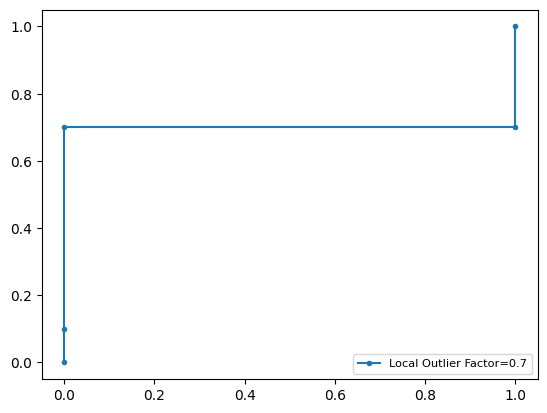

In [40]:
from sklearn import metrics
from matplotlib import pyplot
data = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1]
y_test = pd.DataFrame(data, columns=['Target'])
fpr, tpr, thresholds = metrics.roc_curve(y_test, scores , pos_label=1)
print(thresholds)
#pyplot.plot(fpr, tpr, marker='.', label='Logistic')
auc = metrics.auc(fpr, tpr)
print(auc)

#plt.figure(0).clf()
#fpr, tpr, _ = metrics.roc_curve(y_test, prediction_loss)
#auc = round(metrics.roc_auc_score(y_test, prediction_loss), 4)
plt.plot(fpr,tpr,marker='.',label="Local Outlier Factor="+str(auc))
plt.legend(loc='lower right', prop={'size': 8.2})

In [32]:
X_scores = clf.score_samples(x_test)
print(X_scores)

[-18.6805024  -18.86846371 -18.76857403 -18.72882596 -18.77867454
 -18.7039855  -18.7529082  -18.73168201 -18.76955683 -18.76277811
 -18.72961056 -18.71476014 -18.65344855 -18.7734114  -18.7987578
 -18.78371575 -18.64203127 -18.78556576 -18.79478735 -18.74310586
 -18.75654797 -18.74264878 -18.7275115  -18.7511582  -18.62092307
 -18.75089446 -18.72106527 -18.79307058 -18.74986544 -18.74461425
 -18.8222974  -18.77124366 -18.75929781 -18.97444945 -18.76385294
 -18.78916394 -18.50015872 -18.7038491  -18.66065579 -18.65510927
 -18.68822132 -18.70814958 -18.72628233 -18.63331708 -18.66753201
 -18.9261983  -18.73831706 -18.7167475  -18.70313526 -18.69762574
 -18.86014293 -18.67774844 -18.6530817  -18.6899296  -18.73847107
 -18.60883299 -18.88036239 -18.64810236 -18.90812893 -18.83786982
 -18.72040313 -18.75285061 -18.88682591 -18.75611939 -18.7315777
 -18.74799762 -18.75342481 -18.65322886 -18.68608013 -18.72289754
 -18.72192305 -18.69891585 -18.85571098 -18.69051247 -18.7093439
 -18.68864856

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


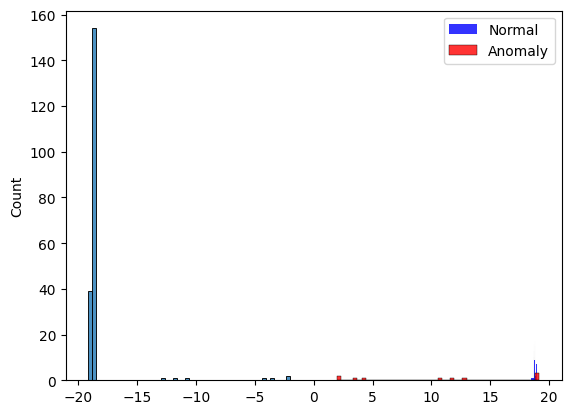

In [33]:
sns.histplot(X_scores, bins=50, alpha=0.8)
X_scores = abs(X_scores)

mse_values_normal_plot = []
mse_values_anomaly_plot = []

for i in range(190):
  mse_values_normal_plot.append(X_scores[i])


count = 190
for i in range(10):
  mse_values_anomaly_plot.append(X_scores[count])
  count = count + 1

sns.histplot(mse_values_normal_plot, bins=50, alpha=0.8, color='blue', label='Normal')
sns.histplot(mse_values_anomaly_plot, bins=50, alpha=0.8, color='red', label='Anomaly')
#plt.axvline(x=loss_threshold, color='orange')
#plt.xlim([0.0, 0.0003])
plt.legend()
plt.show()

In [34]:
average=sum(X_scores)/len(X_scores)
print(average)
for i in range(len(X_scores)):
  X_scores[i] = X_scores[i] - average
X_scores = abs(X_scores)
print(X_scores)

18.355453904631865
[ 0.32504849  0.51300981  0.41312013  0.37337206  0.42322064  0.3485316
  0.3974543   0.37622811  0.41410292  0.4073242   0.37415665  0.35930624
  0.29799465  0.41795749  0.44330389  0.42826184  0.28657736  0.43011186
  0.43933344  0.38765196  0.40109407  0.38719488  0.3720576   0.39570429
  0.26546916  0.39544056  0.36561137  0.43761668  0.39441154  0.38916035
  0.4668435   0.41578976  0.4038439   0.61899554  0.40839904  0.43371003
  0.14470481  0.34839519  0.30520189  0.29965536  0.33276742  0.35269568
  0.37082842  0.27786317  0.3120781   0.5707444   0.38286316  0.3612936
  0.34768136  0.34217183  0.50468902  0.32229453  0.2976278   0.33447569
  0.38301716  0.25337908  0.52490849  0.29264846  0.55267503  0.48241591
  0.36494923  0.3973967   0.531372    0.40066549  0.3761238   0.39254371
  0.3979709   0.29777495  0.33062623  0.36744363  0.36646915  0.34346194
  0.50025707  0.33505857  0.35389     0.33319466  0.3392371   0.35972027
  0.34113013  0.30741588  0.537760

[        inf 16.3567512   0.73270221  0.14470481]
1.0


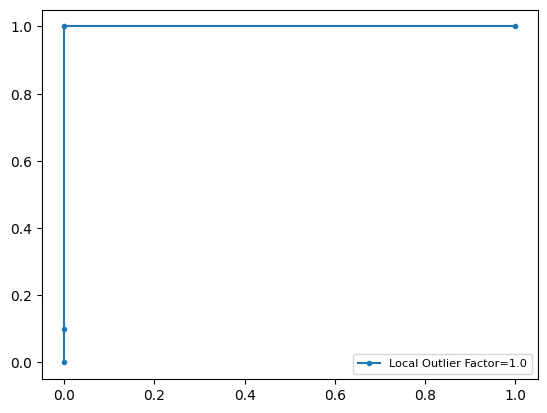

In [35]:
from sklearn import metrics
from matplotlib import pyplot
data = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1]
y_test = pd.DataFrame(data, columns=['Target'])
fpr, tpr, thresholds = metrics.roc_curve(y_test, X_scores , pos_label=1)
print(thresholds)
#pyplot.plot(fpr, tpr, marker='.', label='Logistic')
auc = metrics.auc(fpr, tpr)
print(auc)

#plt.figure(0).clf()
#fpr, tpr, _ = metrics.roc_curve(y_test, prediction_loss)
#auc = round(metrics.roc_auc_score(y_test, prediction_loss), 4)
plt.plot(fpr,tpr,marker='.',label="Local Outlier Factor="+str(auc))
plt.legend(loc='lower right', prop={'size': 8.2})